In [133]:
import geomstats
from geomstats.geometry.spd_matrices import SPDMatrices
from geomstats.geometry.stiefel import Stiefel
from geomstats.datasets.utils import load_connectomes
from geomstats.visualization.spd_matrices import Ellipses
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla

### TODO: introduction

### Loading data

In [134]:
data,ids,target=load_connectomes()
data.shape

(86, 28, 28)

### Manifold of connectomes

In [135]:
# show that connectomes belong to manifold of spd matrices
spd = SPDMatrices(28)
stiefel = Stiefel(28,1)
print(spd.belongs(data),'\n',stiefel.belongs(data))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True] 
 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False Fals

Processing samples

In [136]:
adj_schiz, adj_norm = np.ceil(data[:2])
g_schiz = nx.from_numpy_matrix(adj_schiz)
g_norm = nx.from_numpy_matrix(adj_norm)

### Spatial comparison

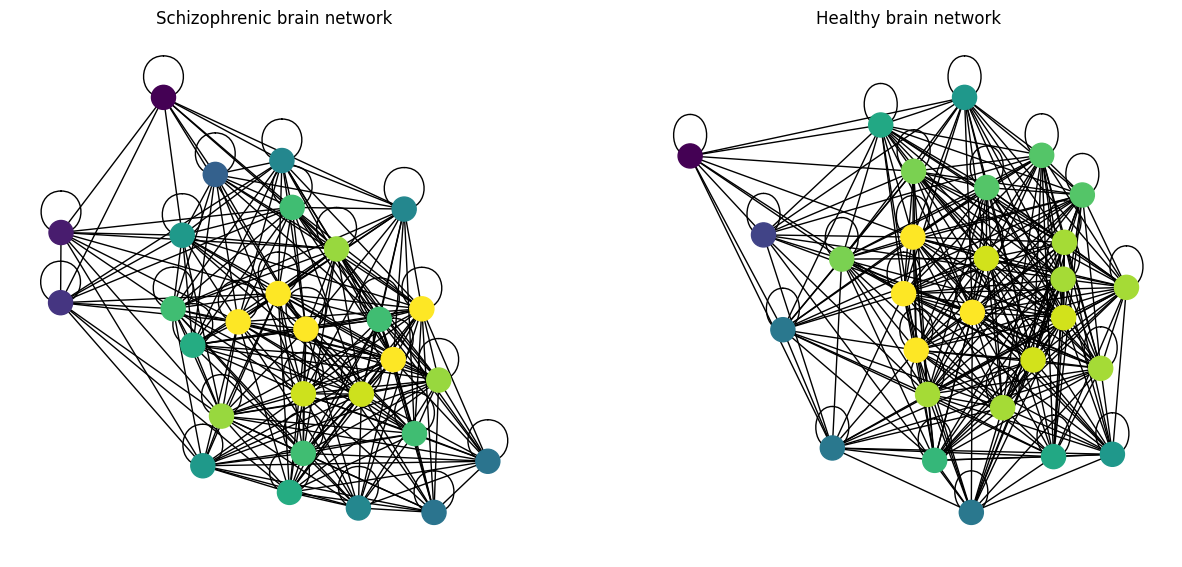

In [137]:
def plot_graphs_spatial(nx_graph,subgraph_id,title):
    plt.subplot(subgraph_id)
    degrees = [n for n in nx.degree_centrality(nx_graph).values()]
    nx.draw(nx_graph,pos=None,with_labels=False,node_color=degrees)
    plt.title(title)

plt.figure(figsize=(15,15))
plot_graphs_spatial(g_schiz,221,"Schizophrenic brain network")
plot_graphs_spatial(g_norm,222,"Healthy brain network")
plt.show()

### Spectral comparison

/var/folders/p9/6kyg2p0x1mjgkqtxh5vvjm9h0000gn/T/ipykernel_43151/3789790737.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  evals,_ = npla.eig(nx.adjacency_matrix(nx_graph).todense())


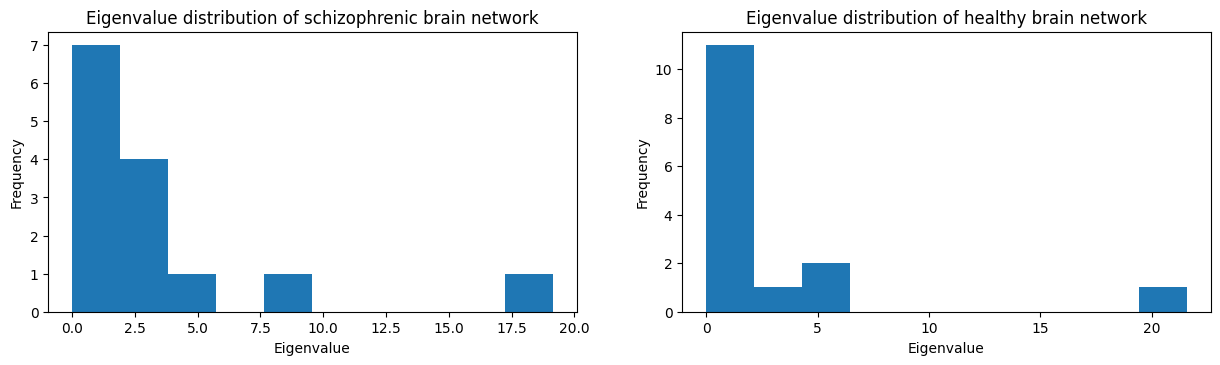

In [150]:
def plot_graphs_spectral(nx_graph,subgraph_id,title):
    evals,_ = npla.eig(nx.adjacency_matrix(nx_graph).todense())
    plt.subplot(subgraph_id)
    plt.hist(evals,range=(0,np.max(evals)))
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title(title)

plt.figure(figsize=(15,8))
plot_graphs_spectral(g_schiz,221,"Eigenvalue distribution of schizophrenic brain network")
plot_graphs_spectral(g_norm,222,"Eigenvalue distribution of healthy brain network")
plt.show()

NOTE: The eigenvalues of the schizophrenic brain network are skewed to higher values. This aligns with the finding in [] that anomalous networks are associated with higher spectral energy.